In [1]:
import os
os.chdir(r'10 - MIDI X-Transformers')
import torch
from miditok import REMI, TokenizerConfig  # here we choose to use REMI
from pathlib import Path
import random
from x_transformers import TransformerWrapper, Decoder
from miditok.utils import split_files_for_training
from miditok.data_augmentation import augment_dataset
from miditok.pytorch_data import DatasetMIDI, DataCollator
from torch.utils.data import DataLoader
from miditok import TokSequence
from multiprocessing import Pool
import tqdm
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import IPython.display
import music21 as m21
from einops import rearrange
import torch.nn.functional as F
musescore_path = '/usr/bin/mscore'
m21.environment.set('musicxmlPath', musescore_path)
m21.environment.set('musescoreDirectPNGPath', musescore_path)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(f"Using {device}.")

Using cuda.


In [ ]:
if device == "cuda":
    print(f"Device: {torch.cuda.get_device_name()}.")

Device: NVIDIA GeForce RTX 4090.


In [3]:
CHUNK_LENGTH = 8193 # Offset by 1 for the labels
TIMESTEPS = 1024
SEGMENTS = (CHUNK_LENGTH - 1) // TIMESTEPS
BATCH_SIZE = 16
VOCAB_SIZE = 716 # REMI basic untrained token count = 411, +chords = 425, +tempos = 457, +time sig = 530, +rests = 562, +chord root note = 716
N_EMBED = 512
N_LAYER = 8
N_HEAD = 8
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 1e-3
NUM_BATCHES = int(1e5)
MAX_GRAD_CLIP_NORM = 0.5
VALIDATE_EVERY  = 64
DIM_HEAD = N_EMBED // N_HEAD
VERSION_LABEL = "X-Transformers-flash-rotary-glu"
TOKENIZER_CONFIG = 'All_Options'

midi_path = Path(f'../data/midi')
dataset_name = 'lakh_clean'
midi_dataset_path = Path(f'{midi_path}/{dataset_name}')
midi_file_paths = [p.resolve() for p in midi_dataset_path.glob("**/*.mid")]

tokenizer_save_path = Path(f'../data/vocab/MidiTok/{dataset_name}_{VOCAB_SIZE}_{TOKENIZER_CONFIG}.json')

if not tokenizer_save_path.exists():
    TOKENIZER_PARAMS = {
        "pitch_range": (21, 109),
        "beat_res": {(0, 4): 8, (4, 12): 4},
        "num_velocities": 32,
        "use_programs": True,
        "program_changes ": True, # Only insert program changes when the instrument changes rather than before every note
        "use_chords": True,
        "chord_tokens_with_root_note": True, # Include the root note in the chord token
        # "use_pitch_bends": True,
        "use_time_signatures": True,
        "delete_equal_successive_time_sig_changes": True, # Only insert time signatures when the time signature changes
        "use_tempos": True,
        "delete_equal_successive_tempo_changes ": True, # Only insert tempos when the tempo changes after downsampling
        "use_rests": True,
    }
    tokenizer_confg = TokenizerConfig(**TOKENIZER_PARAMS)
    tokenizer = REMI(tokenizer_confg)
    print(f"Untrained token count: {tokenizer.len}")
    tokenizer.train(vocab_size=VOCAB_SIZE, files_paths=midi_file_paths)
    tokenizer.save(tokenizer_save_path)
else:
    tokenizer = REMI(params=tokenizer_save_path)

/opt/conda/lib/python3.10/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [4]:
# We split files into train / test / validation folder when we chunk them, so no requirement to set seed here
# random.seed(42)

random.shuffle(midi_file_paths)
len(midi_file_paths)

17256

In [5]:
n1 = int(0.8 * len(midi_file_paths))
n2 = int(0.9 * len(midi_file_paths))
train_filepaths = midi_file_paths[:n1]
valid_filepaths = midi_file_paths[n1:n2]
test_filepaths = midi_file_paths[n2:]

print(f'Train files: {len(train_filepaths)}, Valid files: {len(valid_filepaths)}, Test files: {len(test_filepaths)}')

Train files: 13804, Valid files: 1726, Test files: 1726


In [6]:
chunk_path = Path(f'{midi_path}/mtok_split/{dataset_name}/v-{VOCAB_SIZE}_t-{TOKENIZER_CONFIG}_c-{CHUNK_LENGTH}')
train_chunk_path = Path(f'{chunk_path}/train')
valid_chunk_path = Path(f'{chunk_path}/valid')
test_chunk_path = Path(f'{chunk_path}/test')

split_data = [
    (train_filepaths, train_chunk_path),
    (valid_filepaths, valid_chunk_path),
    (test_filepaths, test_chunk_path)
]

def chunk_files(filepaths, tokenizer, chunks_dir, max_seq_len):
    split_files_for_training(
        files_paths=filepaths,
        tokenizer=tokenizer,
        save_dir=chunks_dir,
        max_seq_len=max_seq_len,
        num_overlap_bars=1
    )
    augment_dataset(
        chunks_dir,
        pitch_offsets=[-12, 12],
        velocity_offsets=[-4, 4],
        duration_offsets=[-0.5, 0.5],
    )

if not chunk_path.exists():
    with Pool(processes=3) as pool:
        pool.starmap(chunk_files, [(filepaths, tokenizer, chunks_dir, CHUNK_LENGTH) for filepaths, chunks_dir in split_data])

# for filepaths, chunks_dir in split_data:
#     chunk_files(filepaths, tokenizer, chunks_dir, CHUNK_LENGTH)

In [7]:
train_chunk_filepaths = list(train_chunk_path.glob("**/*.mid"))
valid_chunk_filepaths = list(valid_chunk_path.glob("**/*.mid"))
test_chunk_filepaths = list(test_chunk_path.glob("**/*.mid"))

print(f'Train chunks: {len(train_chunk_filepaths)}, Valid chunks: {len(valid_chunk_filepaths)}, Test chunks: {len(test_chunk_filepaths)}')

Train chunks: 218143, Valid chunks: 27665, Test chunks: 27428


In [8]:
chunk_paths = [train_chunk_filepaths, valid_chunk_filepaths, test_chunk_filepaths]

for chunk_path in chunk_paths:
    random.shuffle(chunk_path)

In [9]:
from itertools import cycle

def create_data_set(chunks_path, tokenizer, max_seq_len):
    return DatasetMIDI(
        pre_tokenize=False,
        files_paths=chunks_path,
        tokenizer=tokenizer,
        max_seq_len=max_seq_len,
        bos_token_id=tokenizer["BOS_None"],
        eos_token_id=tokenizer["EOS_None"])

def create_data_loader (dataset, tokenizer, batch_size):
    collator = DataCollator(tokenizer.pad_token_id) # copy_inputs_as_labels and shift_labels not needed as done by the transformer
    return cycle(DataLoader(dataset=dataset, collate_fn=collator, batch_size=batch_size, num_workers=8, pin_memory=True))


In [10]:
datasets = map(
    lambda chunk_filepaths: create_data_set(chunk_filepaths, tokenizer, CHUNK_LENGTH),
    chunk_paths
)


In [11]:
train_loader, valid_loader, test_loader = map(
    lambda dataset: create_data_loader(dataset, tokenizer, BATCH_SIZE),
    datasets
)

In [12]:
model_name = f'memorizing_miditok_{dataset_name}_t-{TIMESTEPS}_v-{VOCAB_SIZE}_{VERSION_LABEL}'
model_load_path = Path(f'../data/checkpoints/{model_name}.dat')
model_save_path = Path(f'../data/checkpoints/{model_name}.dat')
log_dir = Path(f'../tensorboard/{model_name}')
tensorboard_writer = SummaryWriter(log_dir)

In [13]:
model = TransformerWrapper(
    num_tokens = VOCAB_SIZE,
    max_seq_len = TIMESTEPS,
    max_mem_len = TIMESTEPS, # XL mem, remember it needs a different training loop (can use xl wrapper). requires rel_pos_bias or rotary_pos_emb
    shift_mem_down = 1,  # Shift memory down for XL mem to enhance the range
    # num_memory_tokens = 20, # https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#memory-transformers
    # attn_num_mem_kv = 16, #https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#augmenting-self-attention-with-persistent-memory
    # l2norm_embed = True # l2norm_embed 
    attn_layers = Decoder(
        dim = N_EMBED,
        depth = N_LAYER,
        heads = N_HEAD,
        # rel_pos_bias = True, # Relative positional embedding
        rotary_pos_emb = True, # A form of relative positional embedding which is compatible with flash attention
        attn_flash = True, # Massive speed up / mem reduction, incompatible with T5
        layer_dropout = 0.1,   # Stochastic depth - dropout entire layer
        attn_dropout = 0.1,    # Dropout post-attention
        ff_dropout = 0.1,       # Feedforward dropout
        ff_glu = True # Leave on  - https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#glu-variants-improve-transformer
        # ff_swish = True, # Use this with glu if you want to
        # use_abs_pos_emb = False,
        # gate_residual = True # Increased perf and stability for T-XL
        # ff_no_bias = True # https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#no-bias-in-feedforward
        # dynamic_pos_bias = True,# You can use this type of relative position if you wish to train at smaller sequence lengths and have it generalize to longer ones, for both autoregressive and bidirectional models.
        # dynamic_pos_bias_log_distance = False   # whether to use log distance, as in SwinV2
        # use_scalenorm = True # https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#transformers-without-tears
        # use_simple_rmsnorm = True # https://github.com/lucidrains/x-transformers/tree/main?tab=readme-ov-file#root-mean-square-layer-normalization
        # attn_sparse_topk = 8,                       # keep only the top 8 values before attention (softmax)
        # attn_sparse_topk_straight_through = True    # straight through the original gradients
        # attn_pre_talking_heads = True,  # linear combination across pre-softmax attn logits across heads. This comes with the cost of extra memory and compute.
        # attn_post_talking_heads = True  # linear combination across post-softmax attn across heads. This comes with the cost of extra memory and compute.
        # attn_qk_norm = True, #  l2 normalize the queries and keys along the head dimension before the dot product (cosine similarity), with the additional change of the scale being learned rather than static. The normalization prevents the attention operation from overflowing, and removes any need for numerical stability measures prior to softmax. Both are perennial problems when training transformers.
        # attn_qk_norm_dim_scale = True # set this to True, in addition to `attn_qk_norm = True`
    )
).to(device)

print(sum(p.numel() for p in model.parameters()))

34333184


In [14]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
token_emb.emb.weight 	 torch.Size([716, 512])
attn_layers.layers.0.0.0.gamma 	 torch.Size([512])
attn_layers.layers.0.1.to_q.weight 	 torch.Size([512, 512])
attn_layers.layers.0.1.to_k.weight 	 torch.Size([512, 512])
attn_layers.layers.0.1.to_v.weight 	 torch.Size([512, 512])
attn_layers.layers.0.1.to_out.weight 	 torch.Size([512, 512])
attn_layers.layers.1.0.0.gamma 	 torch.Size([512])
attn_layers.layers.1.1.ff.0.proj.weight 	 torch.Size([4096, 512])
attn_layers.layers.1.1.ff.0.proj.bias 	 torch.Size([4096])
attn_layers.layers.1.1.ff.2.weight 	 torch.Size([512, 2048])
attn_layers.layers.1.1.ff.2.bias 	 torch.Size([512])
attn_layers.layers.2.0.0.gamma 	 torch.Size([512])
attn_layers.layers.2.1.to_q.weight 	 torch.Size([512, 512])
attn_layers.layers.2.1.to_k.weight 	 torch.Size([512, 512])
attn_layers.layers.2.1.to_v.weight 	 torch.Size([512, 512])
attn_layers.layers.2.1.to_out.weight 	 torch.Size([512, 512])
attn_layers.layers.3.0.0.gamma 	 torch.Size([512])
attn_la

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# For visualizing embeddings from a trained model
def visualize_model_embeddings(model, tokenizer):
    if tokenizer.is_trained:
        all_ids = torch.tensor(list(tokenizer.vocab_model.values())).to(device)
        all_ids_cpu = torch.tensor(list(tokenizer.vocab_model.values()))
    else:
        all_ids = torch.tensor(list(tokenizer.vocab.values())).to(device)
        all_ids_cpu = torch.tensor(list(tokenizer.vocab.values()))
    
    # Get embeddings from model
    with torch.no_grad():
        # Assuming model.wte is the token embedding layer (adjust as needed)
        embeddings = model.token_emb(all_ids).detach().cpu().numpy()
    
    # Apply dimensionality reduction
    tsne = TSNE(n_components=2, perplexity=min(30, len(all_ids_cpu)-1))
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Create categorical color mapping based on token types
    # You can customize this based on your tokenizer's vocabulary
    plt.figure(figsize=(10, 8))
    plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_ids_cpu, cmap='tab20', alpha=0.7)
    plt.colorbar(label='Token ID')
    plt.title('Model Embeddings t-SNE Projection')
    plt.tight_layout()
    plt.show()

In [17]:
from IPython.display import display, clear_output

def save_checkpoint(optimizer, completed_iterations, train_loss, val_loss):
    tensorboard_writer.add_scalar('Loss/train', train_loss, completed_iterations)
    tensorboard_writer.add_scalar('Loss/val', val_loss, completed_iterations)
    clear_output(wait=True)
    print(f'Writing to Tensorboard: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    torch.save({
        'iter': completed_iterations,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict()
    }, model_save_path)
    visualize_model_embeddings(model, tokenizer)

completed_iterations = 0
if model_load_path.exists():
    checkpoint = torch.load(model_load_path)
    completed_iterations = checkpoint['iter']
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    print(f"Loaded model from iteration {completed_iterations}")

Loaded model from iteration 3200


Writing to Tensorboard: Train Loss: 1.4650, Val Loss: 1.1811


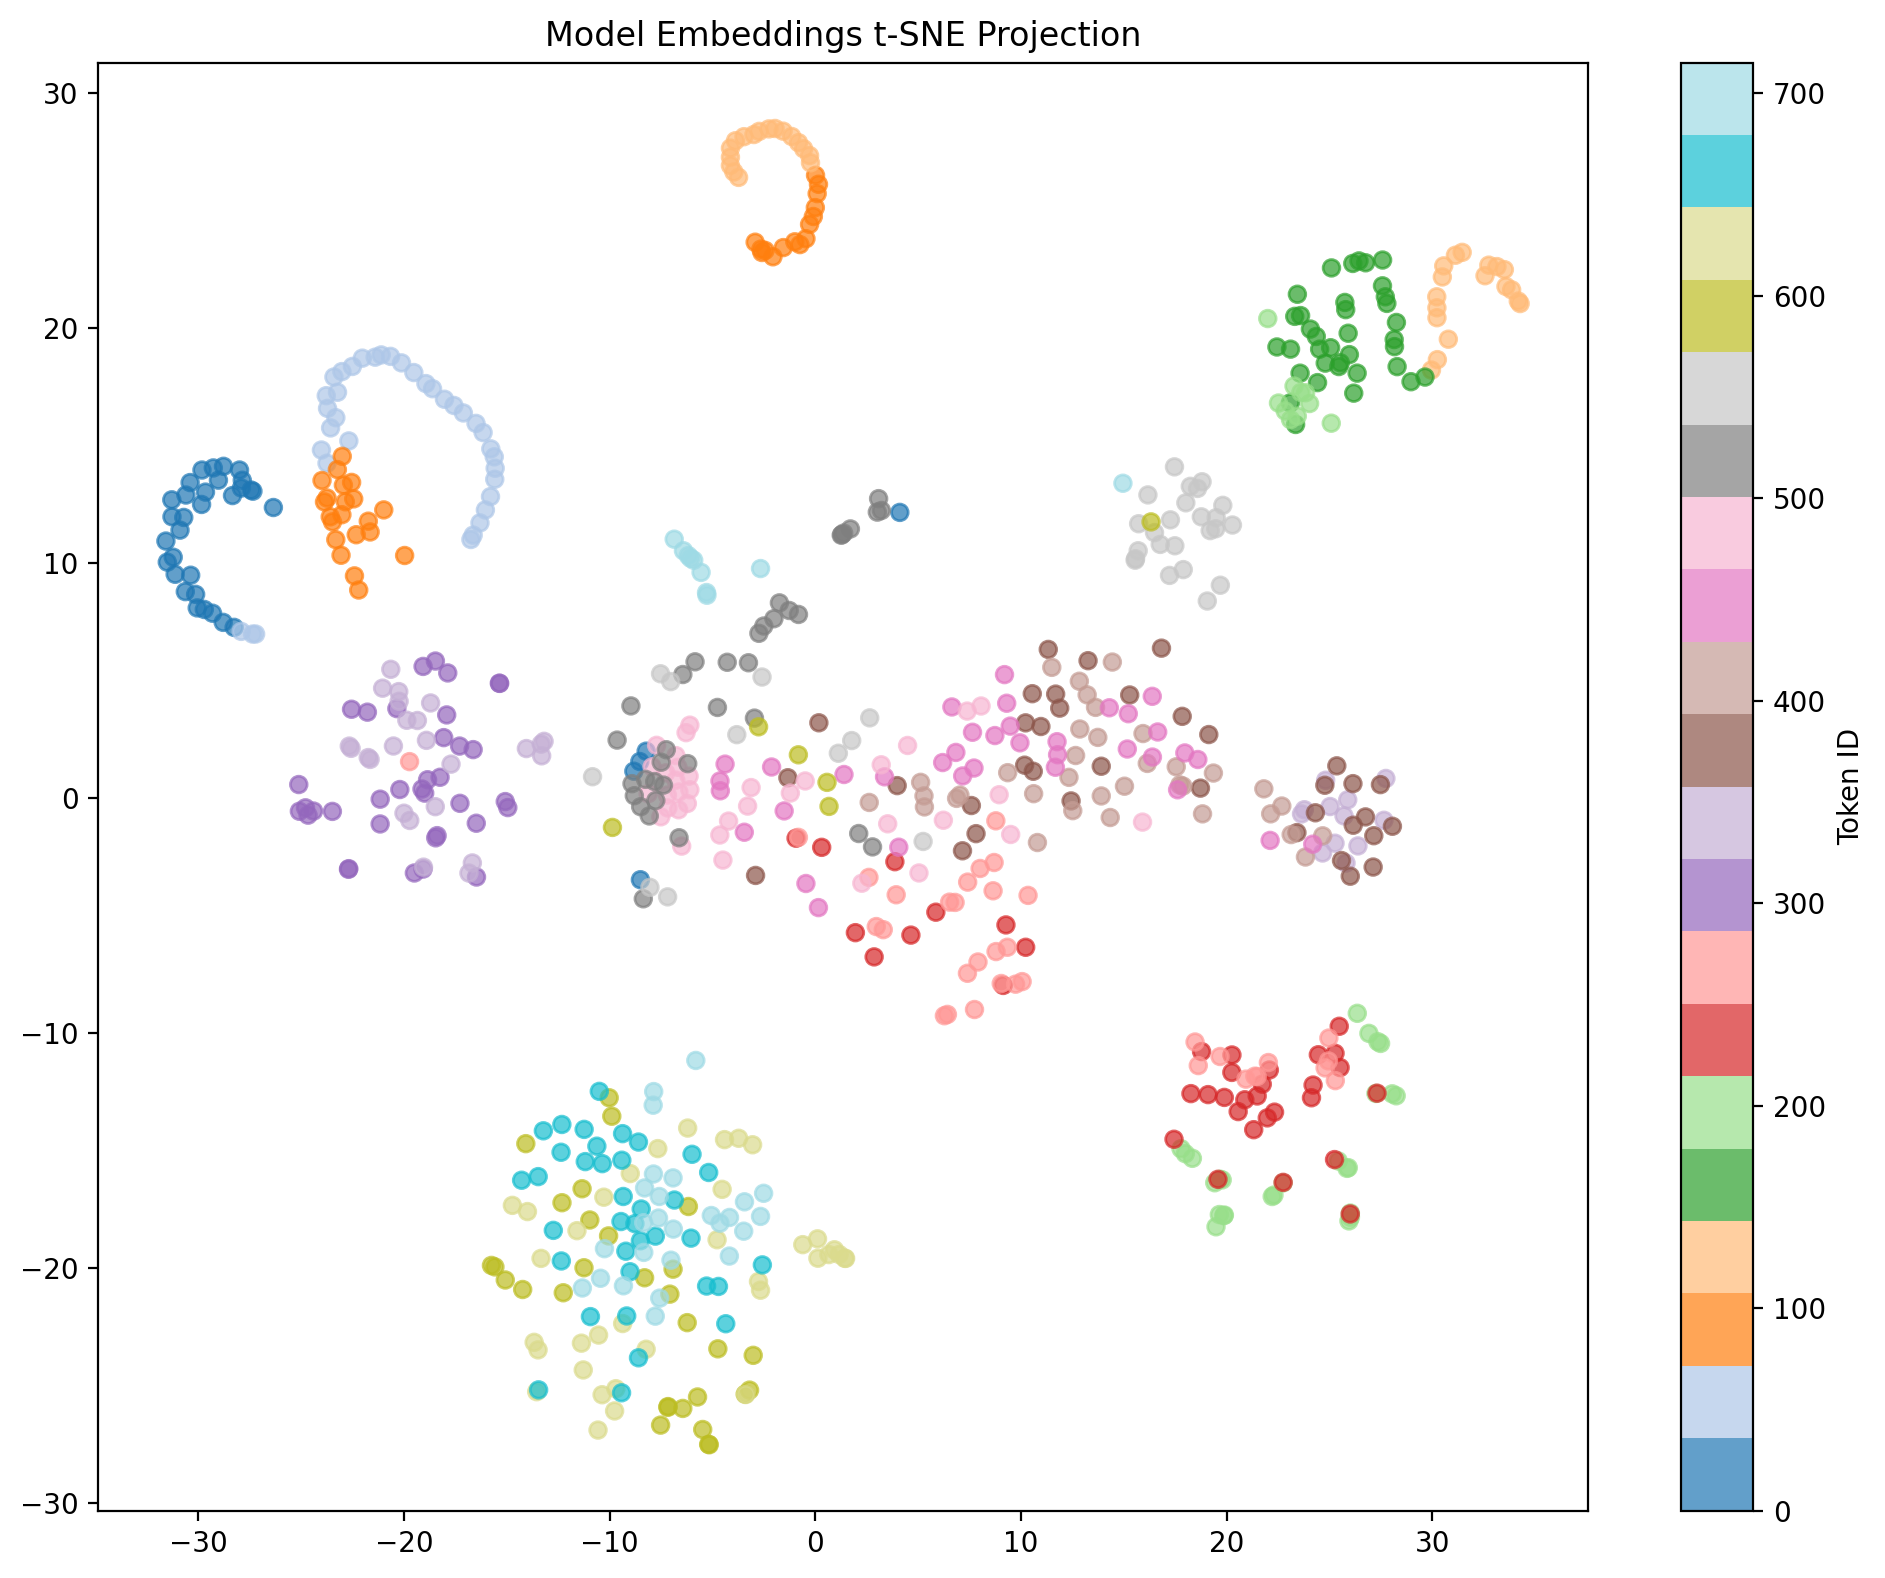

training:   4%|▎         | 3431/96800 [54:08<24:33:34,  1.06it/s]

In [ ]:
scaler = torch.cuda.amp.GradScaler()
loss_fn = F.cross_entropy if not model.output_is_log_prob else F.nll_loss

for i in tqdm.tqdm(range(NUM_BATCHES - completed_iterations), mininterval = 10., desc = 'training'):
    model.train()

    data = next(train_loader)["input_ids"].to(device)
    if data.shape[0] != BATCH_SIZE:
        print(f'Skipping batch {i} as it is not of size {BATCH_SIZE}, but {data.shape[0]}')
        data = next(train_loader)["input_ids"].to(device)

    train_loss = 0.
    xl_memories = None    
    x, y = data[:, :-1], data[:, 1:]

    for seq_segment, labels_segment in zip(x.chunk(SEGMENTS, dim = -1), y.chunk(SEGMENTS, dim = -1)):
        
        with torch.cuda.amp.autocast():
            logits, xl_memories = model(
                seq_segment,
                mems = xl_memories,
                return_mems = True,
            )

            loss = loss_fn(
                rearrange(logits, 'b n c -> b c n'),
                labels_segment,
                ignore_index = tokenizer.pad_token_id
            )

            # loss = torch.clamp(loss, max=2.0)

        train_loss += loss.item() / SEGMENTS
        scaler.scale(loss / SEGMENTS).backward()

    scaler.unscale_(optimizer)
    torch.nn.utils.clip_grad_norm_(model.parameters(), MAX_GRAD_CLIP_NORM)
    scaler.step(optimizer)
    scaler.update()

    optimizer.zero_grad(set_to_none=True)

    if not (i % VALIDATE_EVERY):
        model.eval()

        valid_data = next(valid_loader)["input_ids"].to(device)
        if valid_data.shape[0] != BATCH_SIZE:
            print(f'Skipping validation batch {i} as it is not of size {BATCH_SIZE}, but {valid_data.shape[0]}')
            valid_data = next(valid_loader)["input_ids"].to(device)

        valid_loss = 0.

        xl_memories = None    
        x, y = valid_data[:, :-1], valid_data[:, 1:]

        for seq_segment, labels_segment in zip(x.chunk(SEGMENTS, dim = -1), y.chunk(SEGMENTS, dim = -1)):
            
            with torch.cuda.amp.autocast():
                logits, xl_memories = model(
                    seq_segment,
                    mems = xl_memories,
                    return_mems = True,
                )

                loss = loss_fn(
                    rearrange(logits, 'b n c -> b c n'),
                    labels_segment,
                    ignore_index = tokenizer.pad_token_id
                )

                # loss = torch.clamp(loss, max=2.0)

            valid_loss += loss.item() / SEGMENTS

        save_checkpoint(optimizer, i + completed_iterations, train_loss, valid_loss)

In [ ]:
random_test_path = random.choice(test_chunk_filepaths)
random_train_data = tokenizer.encode(random_test_path)
print(f'Random test file: {random_test_path}')

In [ ]:
from symusic import Synthesizer
synth = Synthesizer()

random_start_tokens = random_train_data.tokens[:TIMESTEPS] # TODO: Think about checking / enforcing the correct length
random_start_ids = random_train_data.ids[:TIMESTEPS]

random_start_decoded = tokenizer.decode(random_start_tokens)
audio = synth.render(random_start_decoded)
IPython.display.Audio(audio, rate=44100)

In [ ]:
def exists(val):
    return val is not None

def generate(
        model,
        input_ids,
        max_length,
        eos_token_id = None,
        temperature = 1.0,
        top_k = 0,
        top_p = 0.9
    ):
        """
        Generates text autoregressively from the model.
        
        Args:
            input_ids (torch.Tensor): Input token ids [batch_size, seq_len]
            max_length (int): Maximum length to generate
            eos_token_id (int, optional): EOS token id for early stopping. Defaults to None.
            temperature (float, optional): Sampling temperature. Defaults to 1.0.
            top_k (int, optional): K for top-k sampling. Defaults to 0 (disabled).
            top_p (float, optional): P for nucleus sampling. Defaults to 0.9.
        
        Returns:
            torch.Tensor: Generated token ids [batch_size, max_length]
        """
        xl_memories = None
        timesteps = input_ids.shape[1]            
            
        # For tracking generated sequence
        generated = input_ids.clone()
    
        # Generate tokens
        for _ in range(max_length - input_ids.shape[1]):
            # Create a copy of generated that is cropped if needed for the forward pass
            input_for_model = generated
            if generated.shape[1] > timesteps:
                input_for_model = generated[:, -timesteps:]
            
            # Forward pass
            logits, xl_memories = model(
                input_for_model,
                mems = xl_memories,
                return_mems = True,
            )
            
            # Get logits for next token prediction
            next_token_logits = logits[:, -1, :]
            
            # Apply temperature
            if temperature != 1.0:
                next_token_logits = next_token_logits / temperature
            
            # Apply top-k filtering
            if top_k > 0:
                indices_to_remove = next_token_logits < torch.topk(next_token_logits, top_k)[0][..., -1, None]
                next_token_logits[indices_to_remove] = -float('Inf')
                
            # Apply top-p (nucleus) filtering
            if top_p < 1.0:
                sorted_logits, sorted_indices = torch.sort(next_token_logits, descending=True)
                cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)
                
                # Remove tokens with cumulative probability above the threshold
                sorted_indices_to_remove = cumulative_probs > top_p
                # Shift the indices to the right to keep also the first token above the threshold
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
                sorted_indices_to_remove[..., 0] = 0
                
                # Scatter sorted tensors to original indexing
                indices_to_remove = sorted_indices_to_remove.scatter(
                    dim=1, index=sorted_indices, src=sorted_indices_to_remove
                )
                next_token_logits[indices_to_remove] = -float('Inf')
            
            # Sample next token
            probs = F.softmax(next_token_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            
            # Append next token to generated sequence
            generated = torch.cat((generated, next_token), dim=1)
            
            # Check if all sequences have hit the EOS token
            if exists(eos_token_id) and (next_token == eos_token_id).all():
                break
            
        return generated

In [ ]:
input_ids = torch.tensor([random_start_ids]).to(device)

model.eval()

generated = generate(
        model = model,
        input_ids = input_ids,
        max_length = CHUNK_LENGTH,
        eos_token_id = tokenizer["EOS_None"]
    ).detach().cpu()[0]
    
score = tokenizer.decode(generated)
generated_decoded = tokenizer.decode(generated)
audio = synth.render(generated_decoded)
IPython.display.Audio(audio, rate=44100)

In [ ]:
from symusic import dump_wav
dump_wav(f"{VERSION_LABEL}-1.wav", audio, sample_rate=44100)
